have one large graph and not many individual graphs (분자처럼 여러 그래프가 있는게 아님)
unlabeled nodes 존재

### Cora dataset
- Nodes : publication
- Edges : citations
- Node features : word vectors
- 7 labels : publication type (NN, RL, 어떤 주제에 대한 논문인지) 

node features에 각 논문에서 어떠한 단어가 몇번나왔는지 센 후 normalize

In [22]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='/home/user/Stuuddddyyyyyyyyyyyyyyyyyyy', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [23]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features : {dataset.num_features}')  #node features
print(f'Number of classes : {dataset.num_classes}') # label
print(50 * '=')

data = dataset[0]

print(data)
print(f'Number of nodes : {data.num_nodes}')
print(f'Number of edges : {data.num_edges}')
print(f'Number of training nodes : {data.train_mask.sum()}')
print(f'Training node label rate : {int(data.train_mask.sum())/data.num_nodes:.2f}')
print(f'Is undirected : {data.is_undirected()}')

Number of graphs: 1
Number of features : 1433
Number of classes : 7
Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes : 2708
Number of edges : 10556
Number of training nodes : 140
Training node label rate : 0.05
Is undirected : True


In [24]:
print(data.x.shape) # 노드 갯수 x feature 수

# normalized word counts
data.x[2707][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0769, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [25]:
# label vector
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [26]:
# test mask에 포함되는 node 확인
data.test_mask

tensor([False, False, False,  ...,  True,  True,  True])

In [28]:
# 연결되어있는 edge
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [53]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# pytorch에서는 꼭 torch.nn.Module에서 override해야함
# __init__으로 초기화를 시켜주는데 super로 torch.nn.Module에 있는 함수들을 불러오는것

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        
        # Initialize layers (2 message passing 단계)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index):
        # First message passing layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)  # training시에만 dropout 할 수 있도록
        
        # Second message passing layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Output layer
        x = F.softmax(self.out(x), dim=1)
        return x
    
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


## Training and Evaluation

In [52]:
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

# Initialize optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
                            lr = learning_rate,
                            weight_decay = decay)

# Define loss function as crossentropy (classification problem이라서)
# crossentropy를 사용하여 probability distribution을 비교
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    # 전체 node에 feature가 있기 때문에 전체 data를 사용하여 모델에 forward 시켜줌. 
    out = model(data.x, data.edge_index)
    # loss 값을 구할때는 label이 있는 node들로만 계산
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    pred = out.argmax(dim=1)
    train_correct = pred[data.train_mask] == data.y[data.train_mask]
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
    optimizer.step()
    return loss, train_acc

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    # 가장 높은 확률로 나온 class 를 pred로 사용
    pred = out.argmax(dim=1)
    # 실제 값과 맞는지 비교
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

losses = []
for epoch in range(0, 1001):
    loss, train_acc = train()
    losses.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch : {epoch:3d}, Loss : {loss:.4f}, Train accuracy : {train_acc:.4f}')



Epoch :   0, Loss : 1.9460, Train accuracy : 0.1429
Epoch : 100, Loss : 1.6487, Train accuracy : 0.5571
Epoch : 200, Loss : 1.4869, Train accuracy : 0.7357
Epoch : 300, Loss : 1.4474, Train accuracy : 0.8000
Epoch : 400, Loss : 1.3799, Train accuracy : 0.8571
Epoch : 500, Loss : 1.3597, Train accuracy : 0.8786
Epoch : 600, Loss : 1.3612, Train accuracy : 0.8714
Epoch : 700, Loss : 1.3271, Train accuracy : 0.8929
Epoch : 800, Loss : 1.3492, Train accuracy : 0.8786
Epoch : 900, Loss : 1.3235, Train accuracy : 0.9071
Epoch : 1000, Loss : 1.2988, Train accuracy : 0.9214


/home/user/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

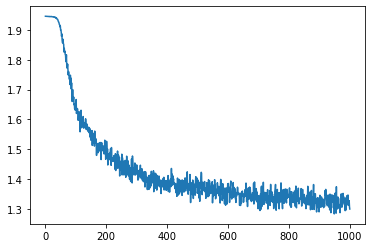

In [37]:
import seaborn as sns
# losses 리스트에 저장되어있는 전체 loss를 numpy로 변환
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
# enumerate를 통해 loss값에 해당하는 인덱스 가져오기
loss_indices = [i for i, l in enumerate(losses_float)]
plt = sns.lineplot(loss_indices, losses_float)
plt

## Calculate test 

In [44]:
test_acc = test()
print(f'Test Accuracy : {test_acc:.4f}')

Test Accuracy : 0.7390


torch.Size([2708, 7])


<AxesSubplot:>

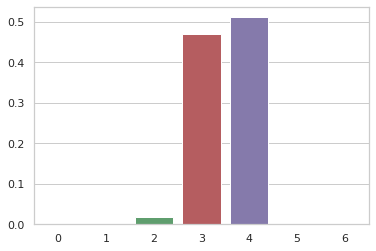

In [50]:
import numpy as np
sample = 2707
sns.set_theme(style='whitegrid')
print(model(data.x, data.edge_index).shape)
# train 후 model이 예측한 결과값
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

### more method to imporve model
- cross validation
- hyperparameter 
- GCN, GAT, ...
- include edge features